In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
from datasets import Dataset as HFDataset, DatasetDict
from medmnist import BreastMNIST, PneumoniaMNIST
from transformers import AutoModelForImageClassification, AutoImageProcessor, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import random
from collections import Counter
from sklearn.utils import resample
import datasets
from scipy.special import softmax

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Parsing
The fist step was to convert the MedMNIST dataset into a format suitable for Hugging Face model, either the datsets suffering by strong unbalancing so we implemented a balanced version for each dataset

In [2]:
class MedMNISTtoHF(Dataset):
    def __init__(self, medmnist_dataset):
        """
        Convert MedMNIST dataset to a format compatible with HuggingFace models
        Args:
            medmnist_dataset: The original MedMNIST dataset
        """
        self.dataset = medmnist_dataset
        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        return {
            "image": img,
            "label": torch.tensor(label, dtype=torch.long)
        }

def convert_medmnist_to_hf(medmnist_dataset):
    """
    Convert a MedMNIST dataset to a HuggingFace dataset
    Args:
        medmnist_dataset: The original MedMNIST dataset
    Returns:
        The HuggingFace dataset
    """
    # Create wrapper dataset
    wrapper_dataset = MedMNISTtoHF(medmnist_dataset)
    
    # Convert to HF format
    images = []
    labels = []
    
    for i in range(len(wrapper_dataset)):
        sample = wrapper_dataset[i]
        images.append(sample["image"])
        labels.append(sample["label"].item())
    
    # Create HF dataset
    hf_dataset = HFDataset.from_dict({
        "image": images,
        "label": labels
    })
    
    return hf_dataset

def dataset_balancing(dataset, alpha):
    """	
    Balance the dataset by oversampling the minority class
    Args:
        dataset: The original dataset
        alpha: The oversampling factor
    Returns:
        The balanced dataset
    """

    mj_class = Counter(dataset['label']).most_common(1)[0][0] # majority class
    mn_class = abs(mj_class-1) # minority class
    data = dataset['image'] # images extracted from the dataset

    mask = [lb== mj_class for lb in dataset['label']] # mask to separate majority and minority class
    X_majority = [img for img,flag in zip(data, mask) if flag] # majority class images
    X_minority = [img for img,flag in zip(data, mask) if not flag] # minority class images
    new_len_majority = len(X_minority) + int(alpha*len(X_minority)) # new length of the majority class
    X_majority_resampled = resample(X_majority, 
                                    replace=False,  # No replacement
                                    n_samples=new_len_majority,  # Match minority class size
                                    random_state=42)
    X_resampled = X_majority_resampled + X_minority # resampled dataset
    y_resampled = [mj_class]*new_len_majority + [mn_class]*len(X_minority) # resampled labels
    random.seed(42)
    random.shuffle(X_resampled) # shuffle the dataset
    random.seed(42)
    random.shuffle(y_resampled) # shuffle the labels

    dict_blanced_dataset = {
        "image": X_resampled,
        "label": y_resampled
    } # dictionary of the balanced dataset
    balanced_dataset = datasets.Dataset.from_dict(dict_blanced_dataset) # convert the dictionary to a HuggingFace dataset
    return balanced_dataset

def load_dataset_medmnist(dataset_name, size, balancing, alpha=0):
    """
    Load a MedMNIST dataset and convert it to a HuggingFace dataset
    Args:
        dataset_name: The name of the MedMNIST dataset
        size: The size of the images
        balancing: Whether to balance the dataset
    Returns:
        The HuggingFace dataset
    """
    # Load MedMNIST dataset
    train_dataset = dataset_name(split='train', download=True, size=size) 
    val_dataset = dataset_name(split='val', download=True, size=size) 
    test_dataset = dataset_name(split='test', download=True, size=size)

    # Convert to HuggingFace dataset
    hf_train_dataset = convert_medmnist_to_hf(train_dataset)
    hf_val_dataset = convert_medmnist_to_hf(val_dataset)
    hf_test_dataset = convert_medmnist_to_hf(test_dataset)

    # Balancing
    if balancing: 
        hf_train_dataset_balanced = dataset_balancing(hf_train_dataset, alpha) # balance the training dataset
        dataset = DatasetDict({"train": hf_train_dataset_balanced, "validation": hf_val_dataset, "test": hf_test_dataset}) 
        return dataset
    else:
        dataset = DatasetDict({"train": hf_train_dataset, "validation": hf_val_dataset, "test": hf_test_dataset})
        return dataset

# Dataset Loading

In [3]:
breast_dataset_28 = load_dataset_medmnist(BreastMNIST, 28, False)
breast_dataset_balanced_28 = load_dataset_medmnist(BreastMNIST, 28, True, 0.5)
breast_dataset_224 = load_dataset_medmnist(BreastMNIST, 224, False, 0.)
breast_dataset_balanced_224 = load_dataset_medmnist(BreastMNIST, 224, True, 0.5)

pneumonia_dataset_28 = load_dataset_medmnist(PneumoniaMNIST, 28, False)
pneumonia_dataset_balanced_28 = load_dataset_medmnist(PneumoniaMNIST, 28, True)
pneumonia_dataset_224 = load_dataset_medmnist(PneumoniaMNIST, 224, False)
pneumonia_dataset_balanced_224 = load_dataset_medmnist(PneumoniaMNIST, 224, True)

Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist_224.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist_224.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist_224.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist_224.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist_224.npz
Using downloaded and verified file: C:\Users\baiet\.medmnist\breastmnist_224.npz
Using downloaded and verified file: C:\Users\baiet\.

# Freezer Functions

In [4]:
def beit_freezer(model):
    for name, param in model.named_parameters():
        if not name.startswith("classifier") \
            and not name.startswith("beit.pooler")\
            and not name.startswith("beit.encoder.layer.23")\
            and not name.startswith("beit.encoder.layer.22")\
            and not name.startswith("beit.encoder.layer.21")\
            and not name.startswith("beit.encoder.layer.20")\
            and not name.startswith("beit.encoder.layer.19"):
            param.requires_grad = False

# Reproducibility Function

In [5]:
def set_reproducibility(seed=42):
    # Set seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Model Function

In [6]:
import matplotlib.pyplot as plt
def T_and_T(dataset, model_name, output_dir, batch_size, weight_decay, Training, Testing, freezer, rc = False):
    """
    Train and test a model on a dataset
    Args:
        dataset: The dataset
        model_name: The model name
        output_dir: The output directory
        batch_size: The batch size
        weight_decay: The weight decay
        Training: Whether to train the model
        Testing: Whether to test the model
        freezer: The function to freeze the layers
        roc_curve: Whether to plot the ROC curve
    """
    # Set Seed
    set_reproducibility()

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Check if GPU is available
    
    # Load the BEiT-large model and image processor
    model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True).to(device) # Load the model
    processor = AutoImageProcessor.from_pretrained(model_name) # Load the image processor

    # Freeze some layers of the model
    freezer(model) 

    # Verify which layers are trainable
    trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
    print(f"Trainable parameters: {trainable_params}")

    # Define preprocessing function
    def preprocess_images(examples):
        images = [processor(image.convert("RGB"), return_tensors="pt") for image in examples["image"]] # Convert images to RGB format
        pixel_values = torch.stack([image["pixel_values"].squeeze() for image in images]) # Stack the pixel values
        labels = torch.tensor(examples["label"]) # Get the labels
        return {"pixel_values": pixel_values, "labels": labels} # Return the pixel values and labels

    # Preprocess the dataset
    train_dataset = dataset["train"].with_transform(preprocess_images)
    validation_dataset = dataset["validation"].with_transform(preprocess_images)
    test_dataset = dataset["test"].with_transform(preprocess_images)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-4,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=5,
        weight_decay=weight_decay, # Regularization
        logging_dir="./logs", 
        logging_steps=10,
        save_total_limit=1,
        remove_unused_columns=False,
        push_to_hub=False,
        seed=42,
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        tokenizer=processor,
    )
    if Training:
        trainer.train()
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

    if Testing:
        predictions = trainer.predict(test_dataset)
        probs = softmax(np.array(predictions.predictions), axis=1)
        y_score = probs[:, 1]
        pred_labels = predictions.predictions.argmax(axis=1)
        true_labels = predictions.label_ids

        # Calculate the metrics
        accuracy = accuracy_score(true_labels, pred_labels)
        auc = roc_auc_score(true_labels, y_score)
        
        # Display the metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc:.4f}")

    if rc:    
        return roc_curve(true_labels, y_score)

# Training and Testing

In [74]:
T_and_T(breast_dataset_28, "microsoft/beit-large-patch16-224-pt22k", "beit_breast_28", 32, 0.01, True, True, beit_freezer)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_19004\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.233300,0.567551
2,0.592600,0.543375
3,0.471200,0.417183
4,0.385600,0.368472
5,0.329900,0.293833


Accuracy: 0.8910
AUC: 0.9098


In [76]:
T_and_T(breast_dataset_balanced_28, "microsoft/beit-large-patch16-224-pt22k", "beit_breast_balanced_28", 16, 0.1, True, True, beit_freezer)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_19004\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.682700,0.713579
2,0.633100,0.425239
3,0.567000,0.455371
4,0.442300,0.296663
5,0.384000,0.283915


Accuracy: 0.8718
AUC: 0.9094


In [77]:
T_and_T(breast_dataset_224, "microsoft/beit-large-patch16-224-pt22k", "beit_breast_224", 32, 0.01, True, True, beit_freezer)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_19004\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.313100,0.727368
2,0.577100,0.448507
3,0.433000,0.351818
4,0.254700,0.255131
5,0.343300,0.261300


Accuracy: 0.8846
AUC: 0.9041


In [78]:
T_and_T(breast_dataset_balanced_224, "microsoft/beit-large-patch16-224-pt22k", "beit_breast_balanced_224", 16, 0.1, True, True, beit_freezer)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_19004\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.733000,0.631535
2,0.662500,0.700516
3,0.562800,0.300123
4,0.304500,0.285772
5,0.212900,0.257996


Accuracy: 0.8782
AUC: 0.9079


Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.8910
AUC: 0.9098
Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.8718
AUC: 0.9094
Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.8846
AUC: 0.9041
Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.8782
AUC: 0.9079


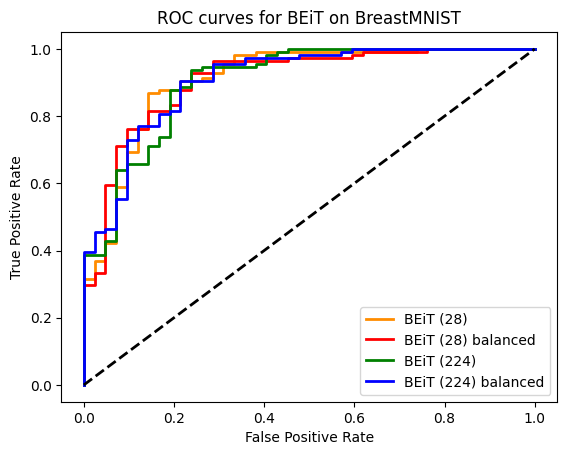

In [16]:
plt.figure()
fpr, tpr, _ = T_and_T(breast_dataset_28, "beit_breast_28", "beit_breast_28", 32, 0.01, False, True, beit_freezer, True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='BEiT (28)')
fpr, tpr, _ = T_and_T(breast_dataset_balanced_28, "beit_breast_balanced_28", "beit_breast_balanced_28", 16, 0.1, False, True, beit_freezer, True)
plt.plot(fpr, tpr, color='red', lw=2, label='BEiT (28) balanced')
fpr, tpr, _ = T_and_T(breast_dataset_224, "beit_breast_224", "beit_breast_224", 32, 0.01, False, True, beit_freezer, True)
plt.plot(fpr, tpr, color='green', lw=2, label='BEiT (224)')
fpr, tpr, _ = T_and_T(breast_dataset_balanced_224, "beit_breast_balanced_224", "beit_breast_balanced_224", 16, 0.1, False, True, beit_freezer, True)
plt.plot(fpr, tpr, color='blue', lw=2, label='BEiT (224) balanced')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for BEiT on BreastMNIST')
plt.legend(loc="lower right")
plt.show()

In [7]:
T_and_T(pneumonia_dataset_28, "microsoft/beit-large-patch16-224-pt22k", "beit_pneumonia_28", 32, 0.1, True, True, beit_freezer)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` in

Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

Epoch,Training Loss,Validation Loss
1,0.112000,0.356054
2,0.107000,0.084922
3,0.059200,0.113743
4,0.031400,0.095352
5,0.031600,0.090858


Accuracy: 0.8814
AUC: 0.9789


In [80]:
T_and_T(pneumonia_dataset_balanced_28, "microsoft/beit-large-patch16-224-pt22k", "beit_pneumonia_balanced_28", 32, 0.1, True, True, beit_freezer)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_19004\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.208500,0.164590
2,0.144500,0.111547
3,0.087900,0.115393
4,0.090400,0.082601
5,0.031200,0.110543


Accuracy: 0.9263
AUC: 0.9743


In [8]:
T_and_T(pneumonia_dataset_224, "microsoft/beit-large-patch16-224-pt22k", "beit_pneumonia_224", 32, 0.1, True, True, beit_freezer)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.083000,0.078202
2,0.059000,0.051133
3,0.036800,0.071912
4,0.011300,0.074980
5,0.019400,0.062890


Accuracy: 0.9119
AUC: 0.9851


In [9]:
T_and_T(pneumonia_dataset_balanced_224, "microsoft/beit-large-patch16-224-pt22k", "beit_pneumonia_balanced_224", 32, 0.1, True, True, beit_freezer)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.163700,0.075950
2,0.164400,0.089383
3,0.024700,0.070563
4,0.025800,0.090314
5,0.022200,0.077566


Accuracy: 0.9183
AUC: 0.9833


Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention.query.weight', 'beit.encoder

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.8814
AUC: 0.9789
Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.9263
AUC: 0.9743
Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.9119
AUC: 0.9851
Trainable parameters: ['beit.encoder.layer.19.lambda_1', 'beit.encoder.layer.19.lambda_2', 'beit.encoder.layer.19.attention.attention.query.weight', 'beit.encoder.layer.19.attention.attention.query.bias', 'beit.encoder.layer.19.attention.attention.key.weight', 'beit.encoder.layer.19.attention.attention.value.weight', 'beit.encoder.layer.19.attention.attention.value.bias', 'beit.encoder.layer.19.attention.output.dense.weight', 'beit.encoder.layer.19.attention.output.dense.bias', 'beit.encoder.layer.19.intermediate.dense.weight', 'beit.encoder.layer.19.intermediate.dense.bias', 'beit.encoder.layer.19.output.dense.weight', 'beit.encoder.layer.19.output.dense.bias', 'beit.encoder.layer.19.layernorm_before.weight', 'beit.encoder.layer.19.layernorm_before.bias', 'beit.encoder.layer.19.layernorm_after.weight', 'beit.encoder.layer.19.layernorm_after.bias', 'beit.encoder.layer.20.lambda_1', 'beit.encoder.layer.20.lambda_2', 'beit.encoder.layer.20.attention.attention

C:\Users\baiet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baiet\AppData\Local\Temp\ipykernel_22756\3341091147.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.9183
AUC: 0.9833


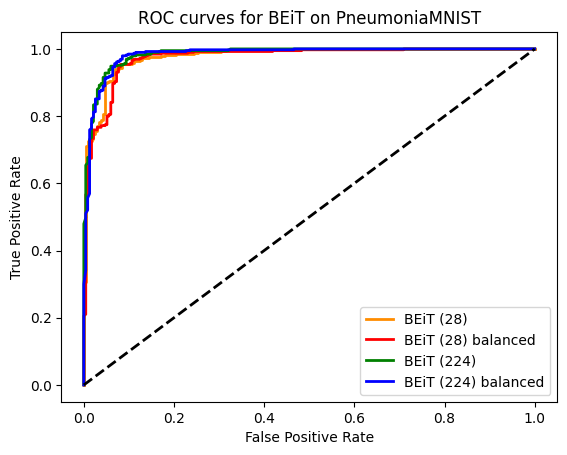

In [15]:
plt.figure()
fpr, tpr, _ = T_and_T(pneumonia_dataset_28, "beit_pneumonia_28", "beit_pneumonia_28", 32, 0.1, False, True, beit_freezer, True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='BEiT (28)')
fpr, tpr, _ = T_and_T(pneumonia_dataset_balanced_28, "beit_pneumonia_balanced_28", "beit_pneumonia_balanced_28", 32, 0.1, False, True, beit_freezer, True)
plt.plot(fpr, tpr, color='red', lw=2, label='BEiT (28) balanced')
fpr, tpr, _ = T_and_T(pneumonia_dataset_224, "beit_pneumonia_224", "beit_pneumonia_224", 32, 0.1, False, True, beit_freezer, True)
plt.plot(fpr, tpr, color='green', lw=2, label='BEiT (224)')
fpr, tpr, _ = T_and_T(pneumonia_dataset_balanced_224, "beit_pneumonia_balanced_224", "beit_pneumonia_balanced_224", 32, 0.1, False, True, beit_freezer, True)
plt.plot(fpr, tpr, color='blue', lw=2, label='BEiT (224) balanced')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for BEiT on PneumoniaMNIST')
plt.legend(loc="lower right")
plt.show()